In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2024-10-06 10:14:14.263859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 10:14:14.263912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 10:14:14.264958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 10:14:14.271837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 10:14:15.998526: W tensorflow/compiler/tf2

In [2]:
%%bash

#Download model weights (data fold 3, 4 replicates)
for rep in f3c0,f0 f3c1,f1 f3c2,f2 f3c3,f3; do IFS=","; set -- $rep; 
  mkdir -p "saved_models/$1/train"
  local_model="saved_models/$1/train/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$1 model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$2/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
mkdir -p hg38/genes/gencode41
mkdir -p hg38/genes/polyadb

if [ -f hg38/genes/gencode41/gencode41_basic_nort.gtf ]; then
  echo "Gene annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_nort.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_nort_protein.gtf ]; then
  echo "Gene annotation (no read-through, protein-coding) already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort_protein.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_nort_protein.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein.gtf ]; then
  echo "Gene annotation (protein-coding) already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_protein.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_tss2.bed ]; then
  echo "TSS annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_tss2.bed.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_tss2.bed
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice site annotation already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz -O hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein_splice.gff ]; then
  echo "Splice site annotation already exist."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.gff.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_protein_splice.gff
fi

if [ -f hg38/genes/polyadb/polyadb_human_v3.csv.gz ]; then
  echo "PolyA site annotation already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz -O hg38/genes/polyadb/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
mkdir -p hg38/assembly/ucsc

if [ -f hg38/assembly/ucsc/hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38/assembly/ucsc/hg38.fa
fi


f3c0 model already exists.
f3c1 model already exists.
f3c2 model already exists.
f3c3 model already exists.
Gene annotation already exists.
Gene annotation (no read-through, protein-coding) already exists.
Gene annotation (protein-coding) already exists.
TSS annotation already exists.
Splice site annotation already exist.
Splice site annotation already exist.
PolyA site annotation already exist.
Human genome FASTA already exists.


In [3]:
pyfaidx.Faidx('hg38/assembly/ucsc/hg38.fa')

Faidx("hg38/assembly/ucsc/hg38.fa")

In [4]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 1       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f3c" + str(rep_ix) + "/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


2024-10-06 10:14:18.639467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38/assembly/ucsc/hg38.fa')

#Load splice site annotation

splice_df = pd.read_csv('hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [6]:
#Print index of GTEx thyroid and nerve tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("thyroid tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:thyroid']['local_index'].tolist()))
print("nerve tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:nerve']['local_index'].tolist()))


thyroid tracks = [81, 82, 83]
nerve tracks = [50, 51]


-- Counts --
 - max_y_wt = 291.0626
 - max_y_mut = 332.1575
 -- (max_y = 332.1575)


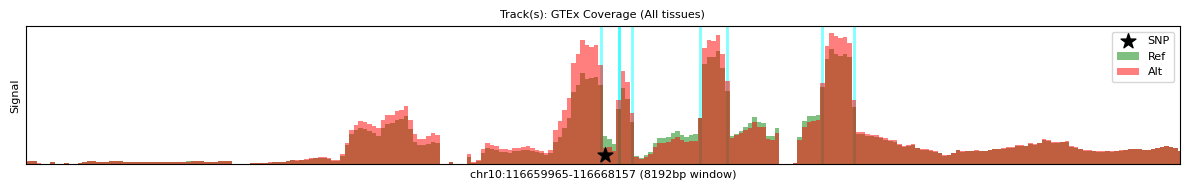

 - max_y_wt = 472.8082
 - max_y_mut = 551.0536
 -- (max_y = 551.0536)


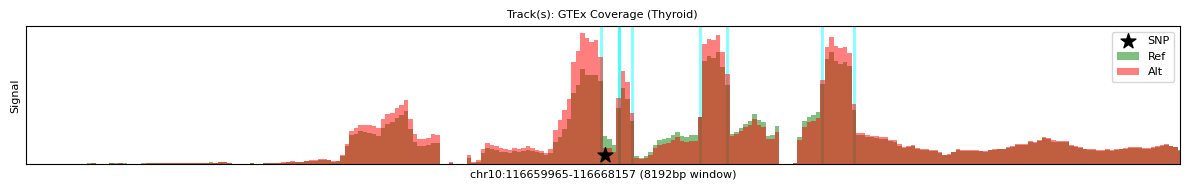

 - max_y_wt = 227.878
 - max_y_mut = 265.866
 -- (max_y = 265.866)


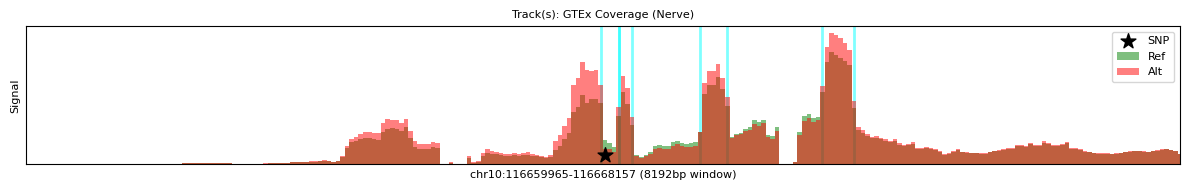

CPU times: user 5.26 s, sys: 313 ms, total: 5.57 s
Wall time: 8.55 s


In [10]:
%%time
#Predict for chr10_116664061_G_A
# (~6 minutes on CPU w 1 replicate; ~15 seconds on GPU)

save_figs = False
save_suffix = '_chr10_116664061_G_A'

center_pos = 116664061

chrom = 'chr10'
poses = [116664061]
alts = ['A']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 4096 * 2
bin_size = 32
pad = 16

untransform_old = True
normalize_counts = False

anno_df = splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [81, 82, 83],
    [50, 51],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Thyroid)',
    'GTEx Coverage (Nerve)',
]

track_scales = [
    0.01,
    0.01,
    0.01,
]

track_transforms = [
    3./4.,
    3./4.,
    3./4.,
]

soft_clips = [
    384.,
    384.,
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(y_wt, y_mut, chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=8*plot_window, bin_size=bin_size, pad=pad, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, anno_df=anno_df, untransform_old=untransform_old)


In [11]:
#Print splice site bin positions and other info

plot_start = center_pos - plot_window // 2
plot_end = center_pos + plot_window // 2

plot_start_bin = (plot_start - start) // bin_size - pad
plot_end_bin = (plot_end - start) // bin_size - pad

mut_bin = (poses[0] - start) // bin_size - pad

#Get splice site positions
splice_poses = splice_df.query("chrom == '" + chrom + "' and position_hg38 >= " + str(plot_start) + " and position_hg38 < " + str(plot_end))['position_hg38'].unique().tolist()

print("mut_bin = " + str(mut_bin))
print("")

#Print splice site positions
for splice_ix, splice_pos in enumerate(splice_poses) :
    
    splice_bin = int((splice_pos - start) // 32) - 16
    
    bin_end = splice_bin + 3
    bin_start = bin_end - 5
    
    print("splice_ix = " + str(splice_ix) + ": bin = " + str(splice_bin) + " (" + str(bin_start) + " - " + str(bin_end) + ")")


mut_bin = 8176

splice_ix = 0: bin = 8175 (8173 - 8178)
splice_ix = 1: bin = 8179 (8177 - 8182)
splice_ix = 2: bin = 8179 (8177 - 8182)
splice_ix = 3: bin = 8182 (8180 - 8185)
splice_ix = 4: bin = 8197 (8195 - 8200)
splice_ix = 5: bin = 8203 (8201 - 8206)
splice_ix = 6: bin = 8224 (8222 - 8227)
splice_ix = 7: bin = 8231 (8229 - 8234)


In [12]:
#Choose splice sites to use for attributions

exon_1_start_bin = 8173
exon_1_end_bin = 8176

exon_2_start_bin = 8176
exon_2_end_bin = 8179


In [10]:
%%time
#Get contribution scores (gradient) for nerve GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    target_index[[50, 51]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_reps).tolist(),
    untransform_old=True,
)


1/1 [==============================] - 220s 220s/step
CPU times: user 18min 44s, sys: 2min 44s, total: 21min 28s
Wall time: 22min 56s


--- WT ---


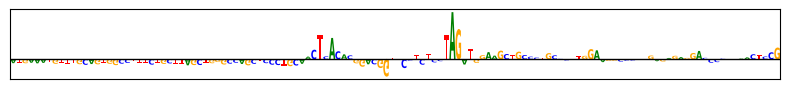

--- Mut ---


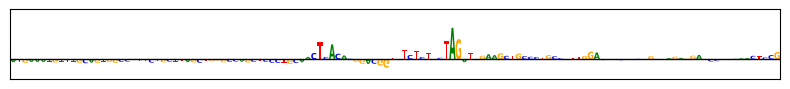

In [11]:
#Visualize gradient contribution scores (128 bp window centered on variant); shown in reverse-complement

visualize_input_gradient_pair(
    pred_grad_wt[::-1, ::-1], #'::-1' on pos and channel axes causes rev-comp
    pred_grad_mut[::-1, ::-1],
    plot_start=seq_len - (poses[0] - start) - 64 - 1,
    plot_end=seq_len - (poses[0] - start) + 64 - 1,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_nerve'
)


In [12]:
%%time
#Get contribution scores (ISM) for nerve GTEX tracks
# (not feasible to run on CPU; ~34 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 15min 42s, sys: 28.5 s, total: 16min 11s
Wall time: 34min 28s


--- WT ---


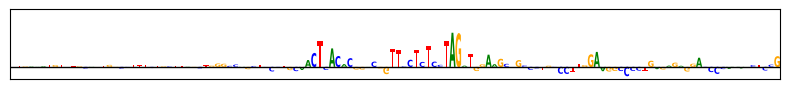

--- Mut ---


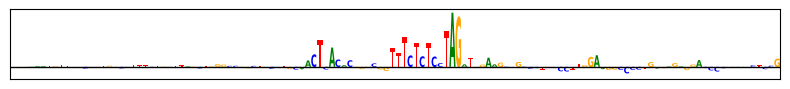

In [13]:
#Visualize ISM contribution scores (128 bp window centered on variant); shown in reverse-complement

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (poses[0] - start) - 64 - 1,
    plot_end=seq_len - (poses[0] - start) + 64 - 1,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_nerve'
)


In [14]:
%%time
#Get contribution scores (ISM shuffle) for nerve GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=12,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 1h 8min 37s, sys: 2min 12s, total: 1h 10min 50s
Wall time: 2h 16min 8s


--- WT ---


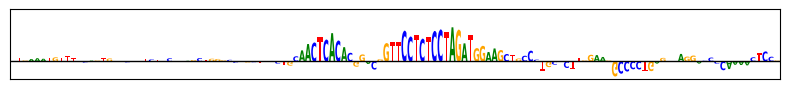

--- Mut ---


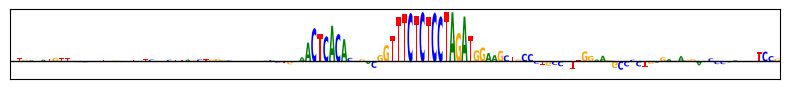

In [15]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant); shown in reverse-complement

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (poses[0] - start) - 64 - 1,
    plot_end=seq_len - (poses[0] - start) + 64 - 1,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_nerve'
)


In [13]:
#Choose new exons to use for attributions (isolate intronic polyadenylation determinant)

pas_pos = 116664310

exon_1_start_bin = 8170
exon_1_end_bin = 8176

exon_2_start_bin = 8197
exon_2_end_bin = 8203


In [17]:
%%time
#Get contribution scores (gradient) for nerve GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    target_index[[50, 51]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_reps).tolist(),
    untransform_old=True,
)


1/1 [==============================] - 220s 220s/step
CPU times: user 18min 23s, sys: 2min 51s, total: 21min 14s
Wall time: 21min 57s


--- WT ---


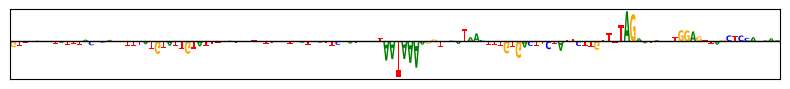

--- Mut ---


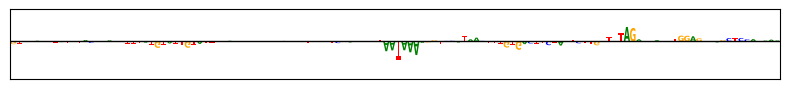

In [18]:
#Visualize gradient contribution scores (128 bp window centered on variant); shown in reverse-complement

visualize_input_gradient_pair(
    pred_grad_wt[::-1, ::-1],
    pred_grad_mut[::-1, ::-1],
    plot_start=seq_len - (pas_pos - start) - 64 - 1,
    plot_end=seq_len - (pas_pos - start) + 64 - 1,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_nerve'
)


In [19]:
%%time
#Get contribution scores (ISM) for nerve GTEX tracks
# (not feasible to run on CPU; ~33 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (pas_pos - start) - 64,
    (pas_pos - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 17min 54s, sys: 31.4 s, total: 18min 26s
Wall time: 33min 54s


--- WT ---


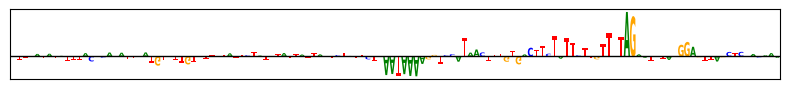

--- Mut ---


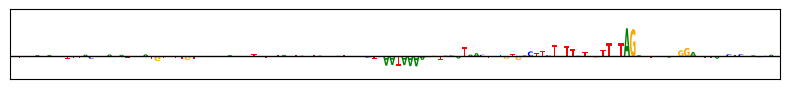

In [20]:
#Visualize ISM contribution scores (128 bp window centered on variant); shown in reverse-complement

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (pas_pos - start) - 64 - 1,
    plot_end=seq_len - (pas_pos - start) + 64 - 1,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_nerve'
)


In [21]:
%%time
#Get contribution scores (ISM shuffle) for nerve GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (pas_pos - start) - 64,
    (pas_pos - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=12,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 1h 11min 31s, sys: 2min 3s, total: 1h 13min 34s
Wall time: 2h 15min 34s


--- WT ---


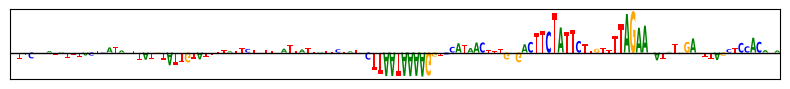

--- Mut ---


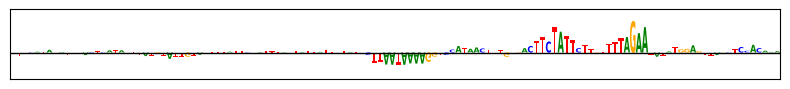

In [22]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant); shown in reverse-complement

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (pas_pos - start) - 64 - 1,
    plot_end=seq_len - (pas_pos - start) + 64 - 1,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_nerve'
)


In [ ]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116664061_G_A.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116664061_G_A.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 31)
gtex_targets_mut.shape = (16352, 31)
-- Counts --
 - max_y_wt = 2566.1792
 - max_y_mut = 2891.292
 -- (max_y = 2891.292)


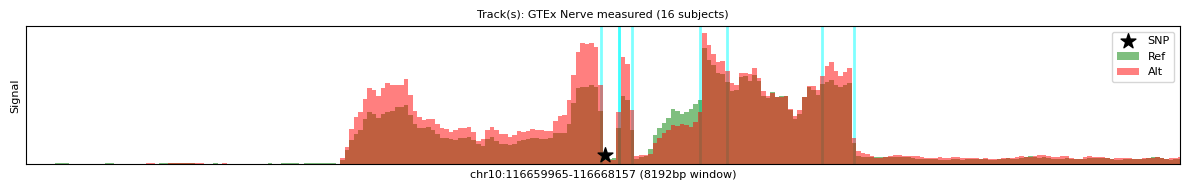

In [24]:
#Read measured coverage tracks for chr10_116664061_G_A

save_figs = False
save_suffix = '_chr10_116664061_G_A_meas_16_subjects'

center_pos = 116664061

chrom = 'chr10'
poses = [116664061]
alts = ['A']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01, transform_old=True)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01, transform_old=True)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 4096 * 2
bin_size = 32
pad = 16

untransform_old = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(16),
]

track_names = [
    'GTEx Nerve measured (16 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(
    gtex_targets_wt[None, None, ...],
    gtex_targets_mut[None, None, ...],
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=8*plot_window,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    anno_df=anno_df,
    untransform_old=untransform_old,
)
